# Reinforcement learning
Auteurs: 
Sami El Kateb
Theo Jeannes

In [81]:
import numpy as np
import keras_tuner
import keras
import pandas as pd
from dataclasses import dataclass

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

pd.options.display.max_columns = 200
keras.utils.set_random_seed(42)

In [82]:
@dataclass
class ProcessedData:
  def __init__(self, X, y):
    self.X = X.copy()
    self.y = y.copy(deep=True)

  def copy(self):
    return ProcessedData(self.X.copy(), self.y.copy())

In [83]:
y = pd.read_csv("./data/y.csv", header=None)
X = pd.read_csv("./data/diff.csv", header=None)
print(y.shape)
print(X.shape)

(16328, 1)
(16328, 2040)


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [98]:
# smoteenn = SMOTEENN(random_state=42)
smoteenn = RandomUnderSampler(random_state=42)
#Ces deux methodes permettent de rééquilibrer les classes pour eviter la surepresentation de la classe 0.
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

ValueError: Found array with dim 4. None expected <= 2.

In [99]:
X_train = X_train.to_numpy().reshape(-1, 40, 51, 1)
X_test = X_test.to_numpy().reshape(-1, 40, 51, 1)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [87]:
X_train.shape

(2679, 40, 51, 1)

In [88]:
y_train.groupby(0)[0].count()

0
0    893
1    893
2    893
Name: 0, dtype: int64

# The dataset is not balanced

In [89]:
sklearn_class_weights = compute_class_weight(class_weight="balanced", classes=y[0].unique(), y=y[0])
class_weight = {}
for i, weight in enumerate(sklearn_class_weights): # Changer le poids des classes n'est plus necessaire, puisque qu'on utilise un RandomUnderSampler pour équilibrer les classes
    class_weight[i] = weight
    
print(class_weight)

{0: 0.4029217253972954, 1: 3.367986798679868, 2: 4.520487264673311}


In [90]:
train = ProcessedData(X_train, y_train)
test = ProcessedData(X_test, y_test)

In [91]:
# Extension de la classe BayesianOptimization pour permettre l'accès aux historiques des modèles entrainés.
class BayesianOptimization(keras_tuner.BayesianOptimization):
    histories = {}

    # À la fin de chaque époque, on ajoute les métriques à l'historique de l'essai en cours
    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items():
            trial_history.setdefault(metric, []).append(value)

In [92]:
def build_model(hp):
    
    input = Input(shape=(40, 51, 1))
    # Optimisation du réseau de neurones
    x = Conv2D(hp.Int(f'conv_filter_0', 3, 9, step=3), hp.Int(f'kernel_size_0', 3, 5, step=2), activation='relu')(input)
    for i in range(hp.Int('layers', 0, 4)):
        x = Conv2D(hp.Int(f'conv_filter_{str(i+1)}', 3, 9, step=3), hp.Int(f'kernel_size_{str(i+1)}', 3, 9, step=2), activation='relu')(x)
        if hp.Boolean("WithMaxPool", default=False):
            x = MaxPooling2D(hp.Int(f'max_pool_size_{str(i+1)}', 2, 6, step=2), strides=hp.Int(f'max_pool_strides_{str(i+1)}', 1, 4, step=10), padding='same')(x)
    x = Flatten()(x)

    output = Dense(3, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=4)

early_stopping_cb = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=1, mode='max', baseline=None, restore_best_weights=True)
tuner.search(train.X, train.y, validation_split=0.2, epochs=1000, callbacks=[early_stopping_cb])

Trial 4 Complete [00h 00m 07s]
val_accuracy: 0.33395522832870483

Best val_accuracy So Far: 0.38432836532592773
Total elapsed time: 00h 00m 44s


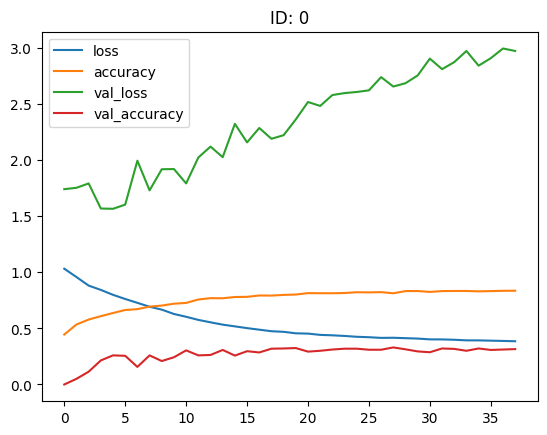

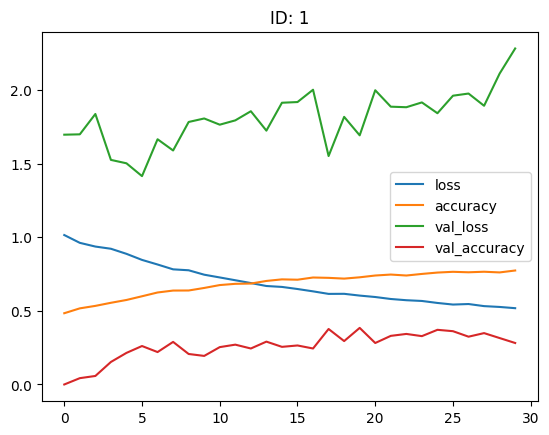

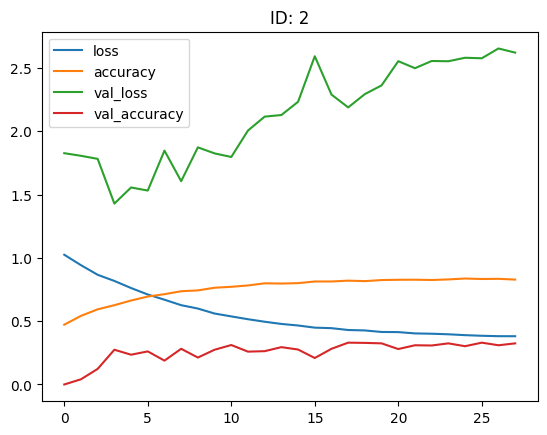

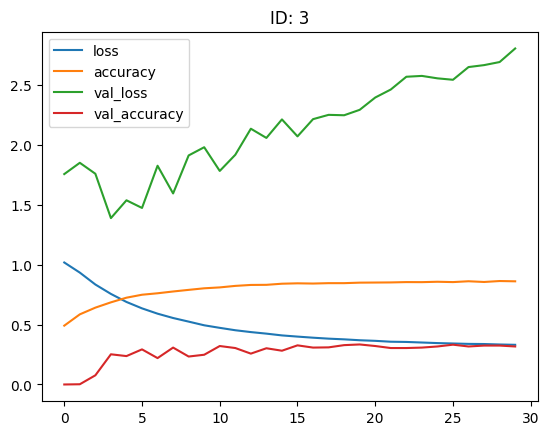

In [93]:
accuracies = [0]*len(tuner.oracle.trials)
losses = [0]*len(tuner.oracle.trials)
model = tuner.get_best_models()[0]
for id_trial, history in tuner.histories.items():
    pd.DataFrame(history).plot(title=f"ID: {id_trial}")
    accuracies[int(id_trial)] = history['val_accuracy']
    losses[int(id_trial)] = history['val_loss']    

,conv_filter_0,kernel_size_0,layers,conv_filter_1,kernel_size_1,WithMaxPool
Modèle 0,9,5,1,3,3,False
Modèle 1,6,3,3,6,5,True
Modèle 2,6,5,1,6,3,False
Modèle 3,9,3,0,3,5,False


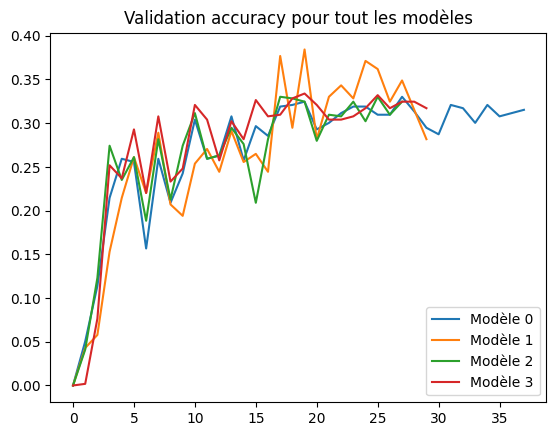

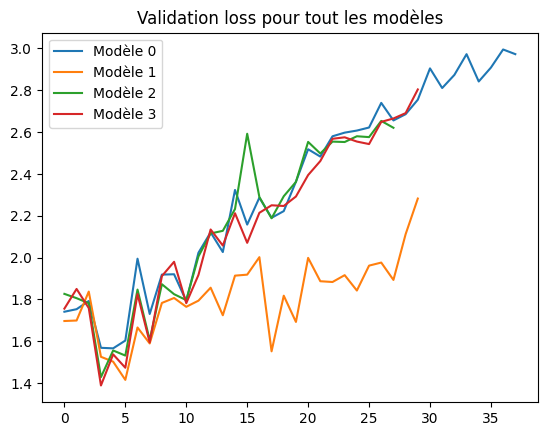

In [94]:
indexes = []
# On compare la precision et la loss sur la validation de chaque modèle.
# Cela permet de visualiser les changements de precisions et de loss en fonction des topologies des modelès
hyperparameters = pd.DataFrame()
length = len(str(len(tuner.oracle.trials)))
for i in range(len(tuner.oracle.trials)):
    number = '0'* (length-(i//10+1)) + str(i)
    indexes.append('Modèle '+str(i))
    hyperparameters['Modèle '+str(i)] = tuner.oracle.get_trial(number).hyperparameters.values
pd.DataFrame(accuracies, index=indexes).T.plot(title="Validation accuracy pour tout les modèles", legend=True)
pd.DataFrame(losses, index=indexes).T.plot(title="Validation loss pour tout les modèles", legend=True)
hyperparameters.T

In [95]:
best_model = tuner.get_best_models()[0] # On récupère le meilleur modèle apres le fine-tuning
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 51, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 38, 49, 6)         60        
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 45, 6)         906       
                                                                 
 max_pooling2d (MaxPooling2  (None, 34, 45, 6)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 43, 3)         165       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 43, 3)         0         
 g2D)                                                        

128/128 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.54      0.67      3379
           1       0.16      0.72      0.27       311
           2       0.24      0.40      0.30       392

    accuracy                           0.54      4082
   macro avg       0.43      0.55      0.41      4082
weighted avg       0.77      0.54      0.60      4082


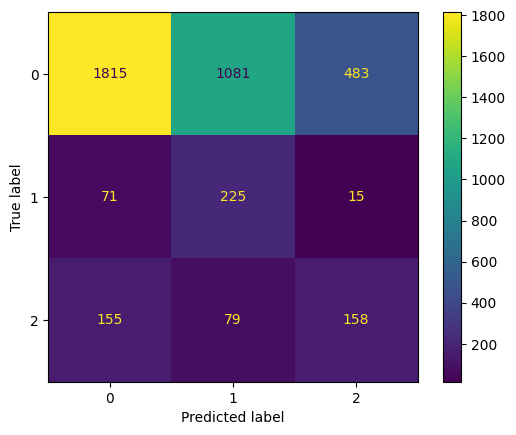

In [96]:
y_pred = best_model.predict(test.X)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test.y, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test.y, y_pred)).plot()

In [97]:
best_model.save(f"./models/pong.h5") # On sauvegarde le meilleur modèle, pour jouer avec eux après

/home/theojeannes/Dev/Scolaire/AppParRenforcement/python/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
